In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go



In [ ]:
# Load in dataset
train_file_path = 'THA2train.xlsx'
validate_file_path = 'THA2validate.xlsx'
train_dataset = pd.read_excel(train_file_path)
validate_dataset = pd.read_excel(validate_file_path)

X_train = train_dataset[['X_0', 'X_1']].values
y_train = train_dataset['y'].values.reshape(-1, 1)
X_val = validate_dataset[['X_0', 'X_1']].values
y_val = validate_dataset['y'].values.reshape(-1, 1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [155]:
#Activation functions
def sigmoid( x): # sigmoid function used at the hidden layer and output layer
    return 1 / (1 + np.exp(-x))
def tanh(x):     # hyperbolic tangent
    return np.tanh(x)
def relu(x):     #RELU
    return np.maximum(0, x)
def leaky_relu(x, alpha=0.01):   #Leaky RELU
    return np.where(x > 0, x, alpha * x)
def elu(x, alpha=1.0):    #exponential LU
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

#Derivative of activation functions
def sigmoid_derivative( x): # sigmoid derivative used for backpropgation
    return sigmoid(x) * (1 - sigmoid(x))
def tanh_derivative(x):
    return 1 - np.tanh(x)**2
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)
def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))

In [156]:
np.random.seed(42)

class MLP:
    def __init__(self, input_size = 2, hidden1_size = 10, hidden2_size = 10, output_size = 2):
        #initialize parameters
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size

        
    def forwardPropogation(self, X):
        #Activation of hidden layer 1
        hidden_layer1 = relu(X.dot(self.weights1) + self.bias1)
        #Activation of hidden layer 2
        hidden_layer2 = relu(hidden_layer1.dot(self.weights2) + self.bias2)
        #Activation of output layer
        output_layer = sigmoid(hidden_layer2.dot(self.weights3) + self.bias3)
        return hidden_layer1, hidden_layer2, output_layer
        
    def backwardPropogation(self,X,y, activation1, activation2, activation3):
        #derivative weights and biases for output layer
        error = activation3 - y
        d_weights3 = activation2.T.dot(error * sigmoid_derivative(activation3))
        d_bias3 = np.sum(error * sigmoid_derivative(activation3), axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 2
        error_hidden2 = error.dot(self.weights3.T) * relu_derivative(activation2)
        d_weights2 = activation1.T.dot(error_hidden2)
        d_bias2 = np.sum(error_hidden2, axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 1
        error_hidden1 = error_hidden2.dot(self.weights2.T) * relu_derivative(activation1)
        d_weights1 = X.T.dot(error_hidden1)
        d_bias1 = np.sum(error_hidden1, axis=0, keepdims=True)
        return d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3
    
    def updateParams(self, d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate):
        self.weights3 -= learning_rate * d_weights3
        self.bias3 -= learning_rate * d_bias3
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        
    
    def bce(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted values
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


    #Test the model
    def test(self, X_val, y_val):
        output_result = []
        
        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_val)

        # Compute validation loss
        val_loss = self.bce(y_val, output_layer)
        #val_loss_history.append(val_loss)
            
        y_val_pred = np.round(output_layer)
        accuracy = np.mean(y_val_pred == y_val)
        
        output_result.append(y_val_pred)
        
        # Confusion matrix
        confusion_matrix = np.zeros((2, 2))
        confusion_matrix[0, 0] = np.sum((y_val == 0) & (y_val_pred == 0))
        confusion_matrix[0, 1] = np.sum((y_val == 0) & (y_val_pred == 1))
        confusion_matrix[1, 0] = np.sum((y_val == 1) & (y_val_pred == 0))
        confusion_matrix[1, 1] = np.sum((y_val == 1) & (y_val_pred == 1))
        
        return accuracy, val_loss, confusion_matrix
    
    def model(self, X, y, X_val, y_val, epochs=100, learning_rate=0.01 , retrain=11, batch_sizes=32):
            sigma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
            accuracy_hist = []
            accuracy_list = []
            for j in range(retrain):


                #Initialize weights
                # initialize weights randomly
                self.weights1 = np.random.normal(0, sigma[j], size=(self.input_size, self.hidden1_size))
                self.weights2 = np.random.normal(0, sigma[j], size=(self.hidden1_size, self.hidden2_size))
                self.weights3 = np.random.normal(0, sigma[j], size=(self.hidden2_size, self.output_size))

                # initialize biases to 0
                self.bias1 = np.zeros((1, self.hidden1_size))
                self.bias2 = np.zeros((1, self.hidden2_size))
                self.bias3 = np.zeros((1, self.output_size))

                train_loss_history = []
                val_loss_history = []
                output_result = []
                batch_size = batch_sizes



                for epoch in range(epochs):
                    for i in range(0, len(X), batch_size):
                        #Batch
                        X_train = X[i : i + batch_size]
                        y_train = y[i : i + batch_size]

                        # forward propogation
                        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_train)
                        output_result.append(output_layer)

                        # Backpropagation
                        d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3 = self.backwardPropogation(X_train,y_train, hidden_layer1, hidden_layer2, output_layer)


                        # Update weights and biases
                        self.updateParams(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate)

                        #Training loss
                        train_loss = self.bce(y_train, output_layer)

                    # Check for early stopping based on validation loss
                    if len(train_loss_history)>100 and train_loss > np.mean(train_loss_history[-10:]):
                        break

                    train_loss_history.append(train_loss)

                    y_train_pred = np.round(output_layer)
                    train_accuracy = np.mean(y_train_pred == y_train)

                    #Test the data
                    val_accuracy, val_loss, confusion_matrix = self.test(X_val, y_val)
                    val_loss_history.append(val_loss)

                accuracy_list.append(val_accuracy)
            accuracy_hist.append(accuracy_list)

    
    def model1(self, X, y, X_val, y_val, epochs=100, learning_rate=0.01 , retrain=11, batch_sizes=32, title="test"):
            sigma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
            accuracy_hist = []
            accuracy_list = []
            for j in range(retrain):


                #Initialize weights
                # initialize weights randomly
                self.weights1 = np.random.normal(0, sigma[j], size=(self.input_size, self.hidden1_size))
                self.weights2 = np.random.normal(0, sigma[j], size=(self.hidden1_size, self.hidden2_size))
                self.weights3 = np.random.normal(0, sigma[j], size=(self.hidden2_size, self.output_size))

                # initialize biases to 0
                self.bias1 = np.zeros((1, self.hidden1_size))
                self.bias2 = np.zeros((1, self.hidden2_size))
                self.bias3 = np.zeros((1, self.output_size))

                train_loss_history = []
                val_loss_history = []
                output_result = []
                batch_size = batch_sizes



                for epoch in range(epochs):
                    for i in range(0, len(X), batch_size):
                        #Batch
                        X_train = X[i : i + batch_size]
                        y_train = y[i : i + batch_size]

                        # forward propogation
                        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_train)
                        output_result.append(output_layer)

                        # Backpropagation
                        d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3 = self.backwardPropogation(X_train,y_train, hidden_layer1, hidden_layer2, output_layer)


                        # Update weights and biases
                        self.updateParams(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate)

                        #Training loss
                        train_loss = self.bce(y_train, output_layer)

                    # Check for early stopping based on validation loss
                    if len(train_loss_history)>100 and train_loss > np.mean(train_loss_history[-10:]):
                        break

                    train_loss_history.append(train_loss)

                    y_train_pred = np.round(output_layer)
                    train_accuracy = np.mean(y_train_pred == y_train)

                    #Test the data
                    val_accuracy, val_loss, confusion_matrix = self.test(X_val, y_val)
                    val_loss_history.append(val_loss)


            
                if epoch%(epochs/10) == 0:
                    print(f"Epoch {epoch+1} Training loss {train_loss} Train Accuracy {train_accuracy:.2f} Validation loss {val_loss} Validation Accuracy {val_accuracy:2f}")


            # Plot training and validation loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title(f'Training Loss - {title}')            
            plt.plot(train_loss_history, label="Training Loss")            
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            # Plot training and validation loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 2)
            plt.plot(val_loss_history, label='Validation Loss')
            plt.title(f'Validation Loss - {title}')           
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()


In [ ]:
# Assuming X_train, y_train, X_val, y_val are already defined

# Define hyperparameter values to iterate over
learning_rates = [0.001, 0.01, 0.1]
hidden1_sizes = [5, 10, 20]
hidden2_sizes = [5, 10, 20]
batch_sizes = [32, 64, 128]

best_val_accuracy = 0
worst_val_accuracy = 100 
best_hyperparameters = {}
worst_hyperparameters = {}
similar_val_accuracy = []

results = []

# Iterate over hyperparameter combinations
for lr in learning_rates:
     for bs in batch_sizes:
        for h1_size in hidden1_sizes:
            for h2_size in hidden2_sizes:
                # Create an instance of the MLP class with current hyperparameters
                mlp_model = MLP(input_size=2, hidden1_size=h1_size, hidden2_size=h2_size, output_size=2)
                print(f"Training with Hidden1 Size:{h1_size}, Hidden2 Size:{h2_size}, Batch Size:{bs}, Learning Rate:{lr}")
                # Train the model
                mlp_model.model(X_train, y_train, X_val, y_val, epochs=100, learning_rate=lr, batch_sizes=bs)

                # Test the model on the validation set
                val_accuracy, _, _ = mlp_model.test(X_val, y_val)
                print(f"Accuracy: {val_accuracy}")

                # Check if current hyperparameters result in better validation accuracy
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_hyperparameters = {'learning_rate': lr, 'hidden1_size': h1_size, 'hidden2_size': h2_size, 'batch_size': bs}
                elif val_accuracy == best_val_accuracy:
                    similar_val_accuracy.append((h1_size,h2_size,bs,lr))
    
               # Check if current hyperparameters result in worse validation accuracy
                if float(val_accuracy) < worst_val_accuracy:
                    worst_val_accuracy = val_accuracy
                    worst_hyperparameters = {'learning_rate': lr, 'hidden1_size': h1_size, 'hidden2_size': h2_size, 'batch_size': bs}
                    
                result_entry = {
                    'Learning Rate': lr,
                    'Hidden1 Size': h1_size,
                    'Hidden2 Size': h2_size,
                    'Batch Size': bs,
                    'Accuracy': val_accuracy
                }
                results.append(result_entry)
                
# Print the best hyperparameters and validation accuracy
print("=================================================================================)
print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_val_accuracy)
print("Worst Hyperparameters:", worst_hyperparameters)
print("Worst Validation Accuracy:", worst_val_accuracy)
print("Other models(hyperparameters) with best validation accuracy(hidden1_size1, hidden1_size2, batch_size, learning_rate):", similar_val_accuracy)
print("=================================================================================)


# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Create a Parallel Coordinates Plot using Graph Objects
fig = go.Figure(data=
    go.Parcoords(
        line=dict(color=results_df['Accuracy'], colorscale='Viridis', showscale=True),
        dimensions=list([
            dict(range=[min(results_df['Learning Rate']), max(results_df['Learning Rate'])],
                 label='Learning Rate', values=results_df['Learning Rate']),
            dict(range=[min(results_df['Hidden1 Size']), max(results_df['Hidden1 Size'])],
                 label='Hidden1 Size', values=results_df['Hidden1 Size']),
            dict(range=[min(results_df['Hidden2 Size']), max(results_df['Hidden2 Size'])],
                 label='Hidden2 Size', values=results_df['Hidden2 Size']),
            dict(range=[min(results_df['Batch Size']), max(results_df['Batch Size'])],
                 label='Batch Size', values=results_df['Batch Size']),
            dict(range=[min(results_df['Accuracy']), max(results_df['Accuracy'])],
                 label='Accuracy', values=results_df['Accuracy']),
        ])
    )
)

# Show the plot
fig.show()


Training with Hidden1 Size:5, Hidden2 Size:5, Batch Size:32, Learning Rate:0.001
Accuracy: 0.9634146341463414
Training with Hidden1 Size:5, Hidden2 Size:10, Batch Size:32, Learning Rate:0.001
Accuracy: 0.9634146341463414
Training with Hidden1 Size:5, Hidden2 Size:20, Batch Size:32, Learning Rate:0.001
Accuracy: 0.9573170731707317
Training with Hidden1 Size:10, Hidden2 Size:5, Batch Size:32, Learning Rate:0.001
Accuracy: 0.975609756097561
Training with Hidden1 Size:10, Hidden2 Size:10, Batch Size:32, Learning Rate:0.001
Accuracy: 0.9695121951219512
Training with Hidden1 Size:10, Hidden2 Size:20, Batch Size:32, Learning Rate:0.001
Accuracy: 0.975609756097561
Training with Hidden1 Size:20, Hidden2 Size:5, Batch Size:32, Learning Rate:0.001
Accuracy: 0.975609756097561
Training with Hidden1 Size:20, Hidden2 Size:10, Batch Size:32, Learning Rate:0.001
Accuracy: 0.975609756097561
Training with Hidden1 Size:20, Hidden2 Size:20, Batch Size:32, Learning Rate:0.001
Accuracy: 0.975609756097561
Tra

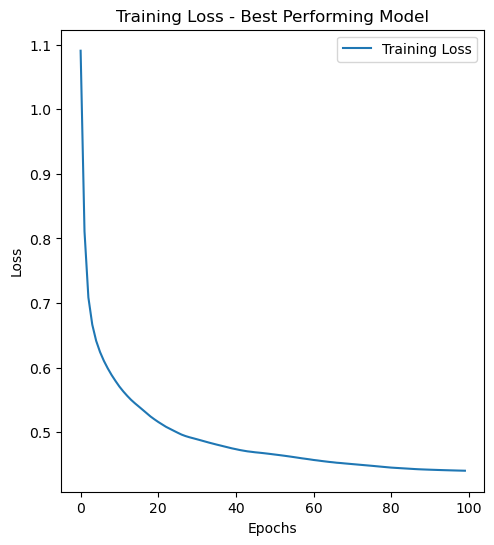

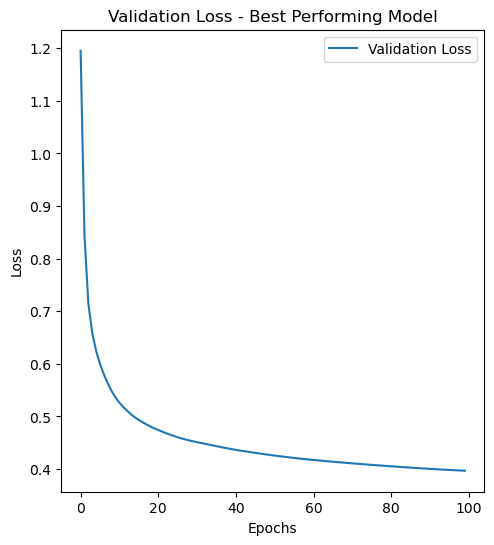

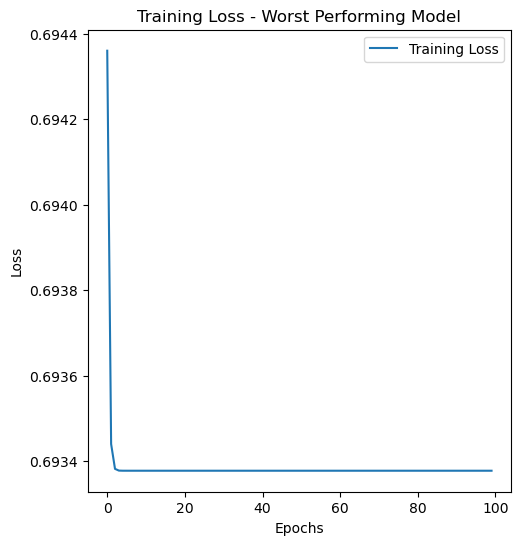

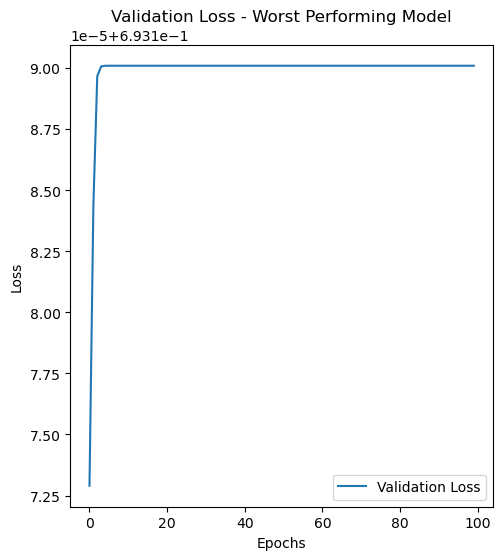

In [158]:
# Best Performing model
mlp2 = MLP(input_size=2, hidden1_size=best_hyperparameters['hidden1_size'], hidden2_size=best_hyperparameters['hidden2_size'], output_size=2)
mlp2.model1(X_train, y_train, X_val, y_val, epochs=100, learning_rate=best_hyperparameters['learning_rate'], batch_sizes=best_hyperparameters['batch_size'], title="Best Performing Model")

# Worst Performing model
mlp2 = MLP(input_size=2, hidden1_size=worst_hyperparameters['hidden1_size'], hidden2_size=worst_hyperparameters['hidden2_size'], output_size=2)
mlp2.model1(X_train, y_train, X_val, y_val, epochs=100, learning_rate=worst_hyperparameters['learning_rate'], batch_sizes=worst_hyperparameters['batch_size'], title="Worst Performing Model")

